# Game Analysis
Here I calculate some statistics about all the games I have played on chess.com (up to 13/06/2021).

## TOC
 - [Read Data](#Read-Data)
 - [Overview of Data](#Overview-of-Data)
 - [Pre-Processing](#Pre-Processing)
 - [Explore Data](#Explore-Data)
  - [Overall Win Rates](#Overall-Win-Rates)
  - [Cummulative Win Rate](#Cummulative-Win-Rate)
  - [Rolling Win Rate](#Rolling-Win-Rate)

In [1]:
import json
import numpy as np
import pandas as pd
import Fetcher as F
import Reader as R

In [278]:
exp_white_win_rate=(.52,.56)
exp_black_win_rate=(.44,.48)

## Read Data
`games.csv` was obtained using `Fetcher.fetch_every_game`.

In [4]:
df=F.__read_csv("data/games.csv")
df=df.rename(columns={"time_control":"time_limit"})

## Overview of Data

In [5]:
df.shape

(909, 10)

The dataset contains 10 fields for 896 games. However, this data has not been fully processed and many of the fields contain more than once piece of data.

In [6]:
# View of data
df.loc[0,:]

url                  https://www.chess.com/game/live/6009142163
pgn           [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
time_limit                                                  600
end_time                                             1608417059
rated                                                      True
fen           rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...
time_class                                                rapid
rules                                                     chess
white         {'rating': 1362, 'result': 'win', '@id': 'http...
black         {'rating': 1038, 'result': 'abandoned', '@id':...
Name: 0, dtype: object

## Pre-Processing
Mainly extracting data from fields which hold multiple pieces of data (`pgn`,`fen`,`white`,`black`)

In [7]:
def process_colour_data(strs:pd.Series,colour:str) -> df:
    dicts=df.loc[:,colour].apply(lambda x:json.loads(x.replace("'","\"")))
    
    new_df=pd.DataFrame()
    new_df[colour+"_rating"]=dicts.apply(lambda x:x["rating"])
    new_df[colour+"_username"]=dicts.apply(lambda x:x["username"])
    new_df[colour+"_result"]=dicts.apply(lambda x:x["result"])
    return new_df

In [8]:
# extract info about players
df=df.merge(process_colour_data(df.loc[:,"white"],"white"), left_index=True, right_index=True)
df=df.merge(process_colour_data(df.loc[:,"black"],"black"), left_index=True, right_index=True)

In [9]:
# my colour
df["my_colour"]=df["white_username"].apply(lambda x: "white" if (x=="DomHutchinson") else "black")
df["opponent_colour"]=df["white_username"].apply(lambda x: "white" if (x!="DomHutchinson") else "black")

In [10]:
# ratings
df["my_rating"]=df.apply(lambda x:x["white_rating"] if (x["white_username"]=="DomHutchinson") else x["black_rating"],axis=1)
df["opponent_rating"]=df.apply(lambda x:x["white_rating"] if (x["white_username"]!="DomHutchinson") else x["black_rating"],axis=1)

In [11]:
df.head(5)

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,white_rating,white_username,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",1362,DomHutchinson,win,1038,GenevievePlenty,abandoned,white,black,1362,1038
1,https://www.chess.com/game/live/6009888217,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,1608424220,True,3r3r/6Q1/4pPkp/p5p1/b2B4/5P2/PP1NN1PP/2R1K2R b...,blitz,chess,"{'rating': 1184, 'result': 'win', '@id': 'http...","{'rating': 1013, 'result': 'resigned', '@id': ...",1184,magnuscarlson78348,win,1013,DomHutchinson,resigned,black,white,1013,1184
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",1227,DomHutchinson,resigned,1390,sri3421,win,white,black,1227,1390
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",1383,ChessGodBossom,win,1142,DomHutchinson,resigned,black,white,1142,1383
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",1032,DomHutchinson,resigned,1081,ElliottSand,win,white,black,1032,1081


In [12]:
# identify winner's colour and reason for outcome
df["winner_colour"]=df.apply(lambda x:"white" if (x["white_result"]=="win") else ("black" if x["black_result"]=="win" else "draw"),axis=1)
df["winner_reason"]=df.apply(lambda x:x["black_result"] if (x["white_result"]=="win") else (x["white_result"] if x["black_result"]=="win" else x["white_result"]),axis=1)

In [13]:
df.head()

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,...,white_result,black_rating,black_username,black_result,my_colour,opponent_colour,my_rating,opponent_rating,winner_colour,winner_reason
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",...,win,1038,GenevievePlenty,abandoned,white,black,1362,1038,white,abandoned
1,https://www.chess.com/game/live/6009888217,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,1608424220,True,3r3r/6Q1/4pPkp/p5p1/b2B4/5P2/PP1NN1PP/2R1K2R b...,blitz,chess,"{'rating': 1184, 'result': 'win', '@id': 'http...","{'rating': 1013, 'result': 'resigned', '@id': ...",...,win,1013,DomHutchinson,resigned,black,white,1013,1184,white,resigned
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",...,resigned,1390,sri3421,win,white,black,1227,1390,black,resigned
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",...,win,1142,DomHutchinson,resigned,black,white,1142,1383,white,resigned
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",...,resigned,1081,ElliottSand,win,white,black,1032,1081,black,resigned


In [14]:
def extract_from_pgn(pgn_str) -> pd.Series:
    pgn_data,pgn_movetext=R.parse_pgn(pgn_str)
    moves=R.parse_san_movetext(pgn_movetext)
    
    s=pd.Series()
    s["date"]=pgn_data["UTCDate"]
    s["opening_code"]=pgn_data["ECO"]
    s["start_time"]=pgn_data["StartTime"]
    s["finish_time"]=pgn_data["EndTime"]
    s["num_moves"]=len(moves)
    s["moves_data"]=moves
    
    return s

In [15]:
pgn_data=df.apply(lambda x:extract_from_pgn(x["pgn"]),axis=1)

c:\users\dom\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [16]:
df=df.merge(pgn_data,left_index=True, right_index=True)

In [17]:
df.head()

,url,pgn,time_limit,end_time,rated,fen,time_class,rules,white,black,...,my_rating,opponent_rating,winner_colour,winner_reason,date,opening_code,start_time,finish_time,num_moves,moves_data
0,https://www.chess.com/game/live/6009142163,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608417059,True,rnbqkb1r/1p2pNp1/p1p2n2/8/2BPP2p/8/PP1N1PPP/R1...,rapid,chess,"{'rating': 1362, 'result': 'win', '@id': 'http...","{'rating': 1038, 'result': 'abandoned', '@id':...",...,1362,1038,white,abandoned,2020.12.19,B12,22:20:55,22:30:59,15,"[(moves pawn to e4., {'special': False, 'piece..."
1,https://www.chess.com/game/live/6009888217,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",300,1608424220,True,3r3r/6Q1/4pPkp/p5p1/b2B4/5P2/PP1NN1PP/2R1K2R b...,blitz,chess,"{'rating': 1184, 'result': 'win', '@id': 'http...","{'rating': 1013, 'result': 'resigned', '@id': ...",...,1013,1184,white,resigned,2020.12.20,C02,00:26:33,00:30:20,43,"[(moves pawn to e4., {'special': False, 'piece..."
2,https://www.chess.com/game/live/6009910283,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608424461,True,rnb1k2r/1ppq1ppp/p3p1n1/8/P2N1P2/2b5/3N2PP/R1B...,rapid,chess,"{'rating': 1227, 'result': 'resigned', '@id': ...","{'rating': 1390, 'result': 'win', '@id': 'http...",...,1227,1390,black,resigned,2020.12.20,B01,00:30:45,00:34:21,24,"[(moves pawn to e4., {'special': False, 'piece..."
3,https://www.chess.com/game/live/6010069847,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608427285,True,8/5pR1/3k4/8/P4P2/bP4P1/6nP/K2N4 b - -,rapid,chess,"{'rating': 1383, 'result': 'win', '@id': 'http...","{'rating': 1142, 'result': 'resigned', '@id': ...",...,1142,1383,white,resigned,2020.12.20,C44,01:02:37,01:21:25,91,"[(moves pawn to e4., {'special': False, 'piece..."
4,https://www.chess.com/game/live/6010223804,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1608428926,True,8/8/P1n2rpk/4p2p/3bP3/1K6/6PP/3R4 b - -,rapid,chess,"{'rating': 1032, 'result': 'resigned', '@id': ...","{'rating': 1081, 'result': 'win', '@id': 'http...",...,1032,1081,black,resigned,2020.12.20,C20,01:34:59,01:48:46,69,"[(moves pawn to e4., {'special': False, 'piece..."


# Explore Data

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18,6]

# Overall Win Rates

In [19]:
f_count_wins=lambda df:df[df["winner_colour"]==df["my_colour"]].shape[0]

In [20]:
n_games=df.shape[0]
n_wins=f_count_wins(df)

print("I have won {:,} games out of {:,}. A win-rate of {:.1f}%".format(n_wins,n_games,100*(n_wins/n_games)))

I have won 424 games out of 909. A win-rate of 46.6%


In [21]:
white_games_df=df[df["my_colour"]=="white"]

n_white_games=white_games_df.shape[0]
n_white_wins =f_count_wins(white_games_df)

print("I have played as white in {:,} games, winning {:,}. A win-rate of {:.1f}%".format(n_white_games,n_white_wins,100*(n_white_wins/n_white_games)))

I have played as white in 452 games, winning 230. A win-rate of 50.9%


In [22]:
black_games_df=df[df["my_colour"]=="black"]

n_black_games=black_games_df.shape[0]
n_black_wins =f_count_wins(black_games_df)

print("I have played as black in {:,} games, winning {:,}. A win-rate of {:.1f}%".format(n_black_games,n_black_wins,100*(n_black_wins/n_black_games)))

I have played as black in 457 games, winning 194. A win-rate of 42.5%


Text(0.5, 1.0, 'Win-Rates vs My Colour')

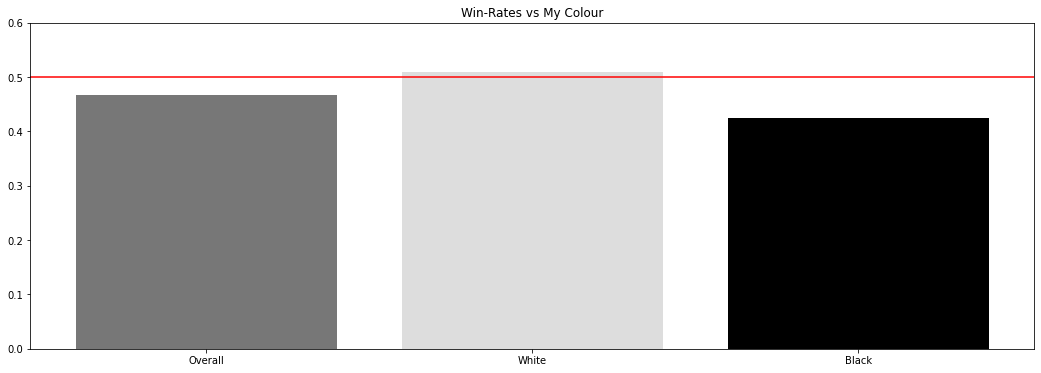

In [31]:
win_rates=[n_wins/n_games,n_white_wins/n_white_games,n_black_wins/n_black_games]
plt.bar(x=[0,1,2],height=win_rates,width=.8,tick_label=["Overall","White","Black"],color=["#777","#ddd","#000"])
plt.ylim(0,.6)
plt.axhline(.5,c="red")
plt.title("Win-Rates vs My Colour")

# Cummulative Win Rate

In [24]:
def calc_cum_wins_losses(df) -> (pd.Series,pd.Series):
    cum_wins=(df["my_colour"]==df["winner_colour"]).cumsum()
    cum_wins=cum_wins.reset_index(drop=True)
    cum_losses=pd.Series(range(1,cum_wins.shape[0]+1))-cum_wins
    return cum_wins,cum_losses

In [25]:
# all games
cum_wins_all,cum_losses_all=calc_cum_wins_losses(df)

# white games
cum_wins_white,cum_losses_white=calc_cum_wins_losses(df[df["my_colour"]=="white"])

# white games
cum_wins_black,cum_losses_black=calc_cum_wins_losses(df[df["my_colour"]=="black"])

In [140]:
# plot cumulative wins and losses against games
def plot_cum_wins_losses(ax,wins,losses,legend=False,title=None,colour=None):
    # plot data
    ax.plot(wins,c="green",label="Wins")
    ax.plot(losses,c="red",label="Losses")
    
    # text
    if legend: ax.legend()
    if title: ax.set_title(title)
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Count")

    # plot line to show net 0
    ax.plot(range(len(wins)),np.linspace(start=0,stop=np.ceil(len(wins)/2),num=len(wins)),c="black")
    
    # emphasise difference
    ax.fill_between(x=range(len(wins)),y1=wins,y2=losses, where=(wins<=losses),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=range(len(wins)),y1=wins,y2=losses, where=(wins>=losses),interpolate=True,color='green',alpha=.2)
    
    # style axes
    ax.margins(0)
    ax.grid()

In [305]:
# plot net cumulative wins and losses against games
def plot_net_cum_wins_losses(ax,wins,losses,legend=False,title=None,colour=None):
    # calculate net
    net=wins-losses
    
    # split data into positive,negative and 0
    pos=np.ma.masked_where(net<0,net)
    neg=np.ma.masked_where(net>0,net)
    non=np.ma.masked_where(net!=0,net)
    
    # plot data (pos=green etc.)
    ax.plot(pos,c="green")
    ax.plot(neg,c="red")
    ax.plot(non,c="gray")
    
    # emphasise difference
    ax.fill_between(x=range(len(net)),y1=net,y2=0, where=(net<=0),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=range(len(net)),y1=net,y2=0, where=(net>=0),interpolate=True,color='green',alpha=.2)
    
    # plot line to show net 0
    ax.axhline(y=0,c="black")
    
    # text
    if title: ax.set_title(title)
    ax.set_xlabel("Games Played")
    ax.set_ylabel("Net Count")
    
    # style axes
    ax.margins(0)
    ax.grid()
    
    # plot expected wins (white) expect losses (black)
    if colour=="white":
        upper_bound=(pd.Series(list(range(len(net))))*(exp_white_win_rate[1]-.5)).tolist()
        lower_bound=(pd.Series(list(range(len(net))))*(exp_white_win_rate[0]-.5)).tolist()
        ax.fill_between(x=list(range(len(net))),y1=upper_bound,y2=lower_bound,interpolate=True,color="green",alpha=.1,label="Exp. Wins")
    elif colour=="black":
        upper_bound=(pd.Series(list(range(len(net))))*(exp_black_win_rate[1]-.5)).tolist()
        lower_bound=(pd.Series(list(range(len(net))))*(exp_black_win_rate[0]-.5)).tolist()
        ax.fill_between(x=list(range(len(net))),y1=upper_bound,y2=lower_bound,interpolate=True,color="red",alpha=.1,label="Exp. Losses")
        
    if legend:
        ax.legend()

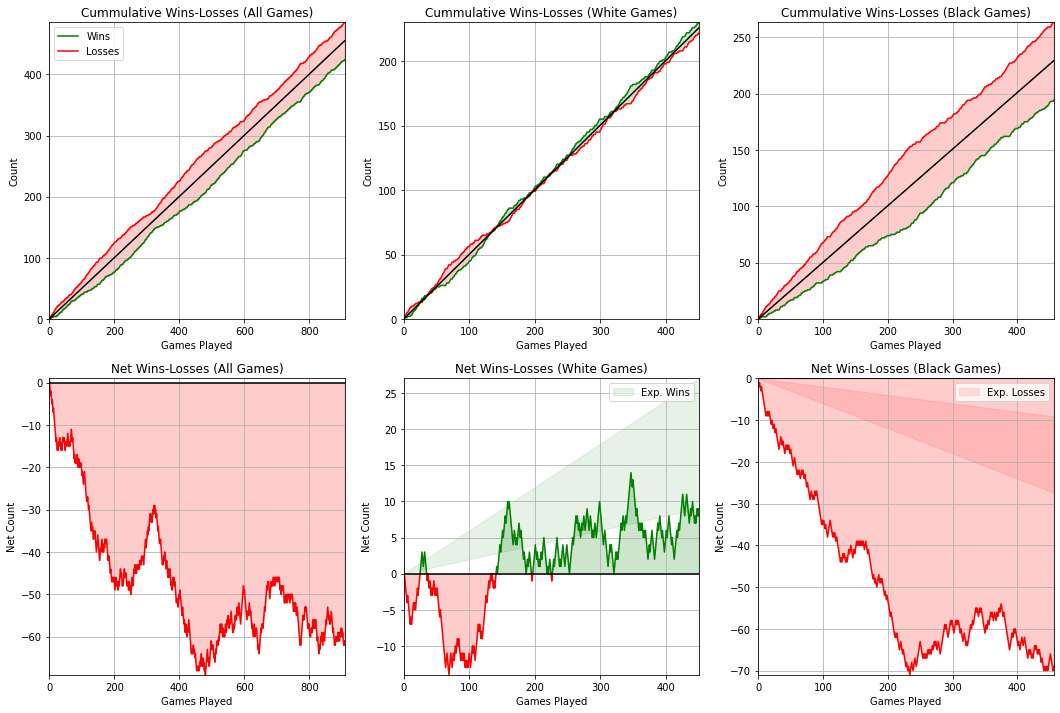

In [307]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(18,12))

plot_cum_wins_losses(ax[0,0],cum_wins_all,cum_losses_all,legend=True,title="Cummulative Wins-Losses (All Games)")
plot_cum_wins_losses(ax[0,1],cum_wins_white,cum_losses_white,title="Cummulative Wins-Losses (White Games)")
plot_cum_wins_losses(ax[0,2],cum_wins_black,cum_losses_black,title="Cummulative Wins-Losses (Black Games)")

plot_net_cum_wins_losses(ax[1,0],cum_wins_all,cum_losses_all,legend=False,title="Net Wins-Losses (All Games)")
plot_net_cum_wins_losses(ax[1,1],cum_wins_white,cum_losses_white,legend=True,title="Net Wins-Losses (White Games)",colour="white")
plot_net_cum_wins_losses(ax[1,2],cum_wins_black,cum_losses_black,legend=True,title="Net Wins-Losses (Black Games)",colour="black")

Basically, I am shite at playing as black and bang average (slightly below average) at white.

# Rolling Win Rate

In [276]:
# calculate rolling wind percentage of the last `trailing n` games
def calc_rolling_win_pct(cum_wins,trailing_n=100,include_start=True) -> pd.Series:
    blanks=pd.Series([0]*trailing_n)
    
    # calc rolling wins
    shifted_wins=blanks.append(cum_wins).reset_index(drop=True)
    extended_wins=cum_wins.append(blanks).reset_index(drop=True)
    rolling_wins=(extended_wins-shifted_wins)[:len(cum_wins)]
    
    # num_to_divide by
    divisors=list(range(1,min(trailing_n,len(cum_wins))))+([trailing_n]*max(0,len(cum_wins)-trailing_n+1))
    divisors=pd.Series(divisors)
    
    if include_start: return rolling_wins/divisors
    else: return (rolling_wins[trailing_n:]/trailing_n)

In [279]:
def plot_rolling_win_pct(ax,rolling_data,trailing_n=None,include_legend=False,title=None,colour=None):
    """
    PARAMS
    rolling_data - data from `calc_rolling_win_pct()`
    colour - colour of player in games (None,"white","black"). Used to plot expected win rates
    """
    xs=rolling_data.index
    
    # split data into positive,negative and 0
    pos=np.ma.masked_where(rolling_data<.5,rolling_data)
    neg=np.ma.masked_where(rolling_data>.5,rolling_data)
    non=np.ma.masked_where(rolling_data!=.5,rolling_data)
    
    # plot data (pos=green etc.)
    ax.plot(xs,pos,c="green")
    ax.plot(xs,neg,c="red")
    ax.plot(xs,non,c="gray")
    
    # plot neutral win rate & full-roll point
    ax.axhline(y=.5,c="black",ls="-")
    ax.axvline(x=trailing_n,c="black",ls="--")
    
    # emphasise difference
    ax.fill_between(x=xs,y1=rolling_data,y2=.5, where=(rolling_data<=.5),interpolate=True,color='red',alpha=.2)
    ax.fill_between(x=xs,y1=rolling_data,y2=.5, where=(rolling_data>=.5),interpolate=True,color='green',alpha=.2)
    
    # style axes
    ax.set_ylim(.3,.7)
    ax.margins(0)
    ax.grid()
    
    # text
    if title:
        title_text=title
        if (trailing_n): title_text+=" for last {} game{}".format(trailing_n,"s" if trailing_n>1 else "")
        ax.set_title(title_text)
    
    # plot POIs
    if trailing_n:
        # plot min (after first `trailing_n` games)
        min_val=min(rolling_data.loc[trailing_n:,])
        min_xs=rolling_data[rolling_data==min_val].index.tolist()
        min_vals=[min_val]*len(min_xs)
        
        func_c=lambda x:"green" if x>.5 else ("gray" if x==.5 else "red")
        
        ax.scatter(min_xs,min_vals,marker="X",s=50,c=func_c(min_val),label="Min Value={:.2f}".format(min_val))
        
        # plot max (after first `trailing_n` games)
        max_val=max(rolling_data.loc[trailing_n:,])
        max_xs=rolling_data[rolling_data==max_val].index.tolist()
        max_vals=[max_val]*len(max_xs)
        
        ax.scatter(max_xs,max_vals,marker="X",s=100,c=func_c(max_val),label="Max Value={:.2f}".format(max_val))
    
    # plot expected win rates
    if (colour=="white"):
        ax.fill_between(x=xs,y1=exp_white_win_rate[0],y2=exp_white_win_rate[1],interpolate=True,color='blue',alpha=.2,label="Expected Win Rate")
    elif (colour=="black"):
        ax.fill_between(x=xs,y1=exp_black_win_rate[0],y2=exp_black_win_rate[1],interpolate=True,color='blue',alpha=.2,label="Expected Win Rate")
    
    if include_legend: ax.legend()

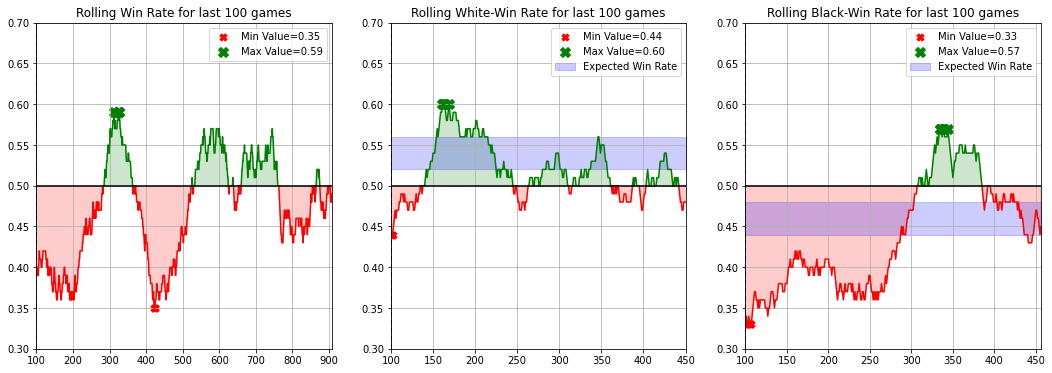

In [280]:
trailing_n=100

# calculate rolling win rates
rolling_wins=calc_rolling_win_pct(cum_wins_all,trailing_n=trailing_n,include_start=False)
rolling_white_wins=calc_rolling_win_pct(cum_wins_white,trailing_n=trailing_n,include_start=False)
rolling_black_wins=calc_rolling_win_pct(cum_wins_black,trailing_n=trailing_n,include_start=False)

# plot data
fig,ax=plt.subplots(nrows=1,ncols=3)
plot_rolling_win_pct(ax[0],rolling_wins,trailing_n=trailing_n,include_legend=True,title="Rolling Win Rate")
plot_rolling_win_pct(ax[1],rolling_white_wins,trailing_n=trailing_n,include_legend=True,colour="white",title="Rolling White-Win Rate")
plot_rolling_win_pct(ax[2],rolling_black_wins,trailing_n=trailing_n,include_legend=True,colour="black",title="Rolling Black-Win Rate")

In [250]:
def calc_time_with_given_win_rate(rolling_data,cond=lambda x:x>=.5) -> float:
    return (rolling_data.apply(cond)).sum()/rolling_data.shape[0]

In [271]:
pct_all=calc_time_with_given_win_rate(rolling_wins[trailing_n:],cond=lambda x:x>=.5)
pct_white=calc_time_with_given_win_rate(rolling_white_wins[trailing_n:],cond=lambda x:x>=.5)
pct_black=calc_time_with_given_win_rate(rolling_black_wins[trailing_n:],cond=lambda x:x>=.5)

print("After the first {} games, I had a positive rolling win rate {:.1f}% of the time.".format(trailing_n,pct_all*100))
print("After the first {} white games, I had a positive rolling white-win rate {:.1f}% of the time.".format(trailing_n,pct_white*100))
print("After the first {} black games, I had a positive rolling black-win rate {:.1f}% of the time.".format(trailing_n,pct_black*100))

After the first 100 games, I had a positive rolling win rate 46.0% of the time.
After the first 100 white games, I had a positive rolling white-win rate 78.6% of the time.
After the first 100 black games, I had a positive rolling black-win rate 32.3% of the time.


# Reasons for Losses

In [325]:
for x in set(df["white_result"].unique().tolist()+df["black_result"].unique().tolist()): print(x)

stalemate
insufficient
win
repetition
resigned
timeout
agreed
timevsinsufficient
checkmated
abandoned


# Pieces Used

 * Number of moves per piece.
 * Takes per piece (after n turns; across whole game)
 * Heatmap for piece position (after n turns; across whole game)

# ELO

 * My rating
 * Average rating beaten/lost to (rolling over time)

# Dates

* Day with most games/losses/wins
* Day with greatest win-rate.
* By DoW.
* Days since last game.
* Win-rate as a function of time since last game.